In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import FacesReconstruction as FR
import kernel as kernel
from kcnmf import KCNMF

<h2>Preprocessing</h2>

In [2]:
fr = FR.FacesReconstruction(0.4,0.5)
fr.load_CMU_dataset('/home/rajaquep/datasets/CMU(30x11x21x1024).mat')

[('FullTensor', (30, 11, 21, 1024), 'uint8')]
Tensor order: (30, 11, 21, 1024)
Matrization order: (6930, 1024)


In [3]:
msk = fr.incomplete_data(fr.MF, fr.rt_obinc, fr.rt_miss)
print msk.shape

(6930, 1024)


<h1>Reconstructing one pixel in one image</h1>

In [4]:
#only one image
image = 100
pixel = 330
msk2 = fr.incomplete_face(image,pixel)
print fr.pixel_completes.shape, fr.pixel_incompletes.shape

(1023,) (1,)


In [11]:
#parameters
mod_params = {'model': 'Pixel', 
              'sigmap': 2, 
              'sigmax': 1, 
              'sigmay': 1, 
              'bases': 300, 
              'normalizeh': 3,
              'normalizea': 6}

In [6]:
#Tensorial Kernel
kx_ = kernel._get_kernel((fr.X[fr.pixel_incompletes], 0), np.stack((fr.X.T,np.zeros(len(fr.X)).T), axis = 1),'rbf', gamma=(2*mod_params['sigmax'])**-2)
ky_ = kernel._get_kernel((fr.Y[fr.pixel_incompletes], 0), np.stack((fr.Y.T,np.zeros(len(fr.Y)).T), axis = 1),'rbf', gamma=(2*mod_params['sigmay'])**-2)
kt_ = kx_ * ky_

Pixel: [10] [10] [136]


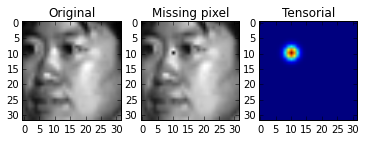

In [7]:
#Visualization
print 'Pixel:', fr.X[fr.pixel_incompletes], fr.Y[fr.pixel_incompletes], fr.MF[image][fr.pixel_incompletes]
f, axarr = plt.subplots(1, 3)
axarr[0].imshow( np.reshape(fr.MF[image],(32,32)).T, cmap='Greys_r' )
axarr[0].set_title('Original')
axarr[1].imshow( np.reshape(fr.Pixel,(32,32)).T, cmap='Greys_r' )
axarr[1].set_title('Missing pixel')
axarr[2].imshow(np.reshape( kt_ ,(32,32)).T)
axarr[2].set_title('Tensorial')

In [8]:
#compute kcnmf over complete objects
fr.model_training(mod_params)
print '(rbf kernel) rse:',np.linalg.norm(fr.Kt - np.dot(fr.kcnmf.W,fr.kcnmf.H))/np.linalg.norm(fr.Kt)
#compute H~ using pseudo inverse
fr.pseudinv_H()

(rbf kernel) rse: 0.255395087001


In [9]:
fr.H4_i.shape

(300, 1)

<h2>Pre-image method </h2>

Using the fixed point iteration method for Gaussian kernel we derivate the next formulation:

$$ x^*_{t+1} = \frac{\sum_{i=1}^n\alpha_i exp(-||\hat{x}^*_t-\hat{x_i}||^2/2\sigma^2)x_i}{\sum_{i=1}^n\alpha_i exp(-||\hat{x}^*_t-\hat{x}_i||^2/2\sigma^2)}$$

<b>Upgrated version:</b>
$exp(-||\hat{x}^*_t-\hat{x_i}||^2/2\sigma^2)$ corresponds to the kernel computed for pixel coordinates and $x_i$ is the $i$ pixel intensity.


In [22]:
#upgrated version
fr.preimage(preimage_method = 2, kernel_method = 'other')

9.66666666667


[inf]

<h2>Naive model (average)</h2>
$$x^* = \frac{1}{|M|}\sum_{x_j\in M}x_j $$ 
Where $M$ is a pixel neighbourhood

In [13]:
print 'Pixel:', fr.X[fr.pixel_incompletes], fr.Y[fr.pixel_incompletes]
x =  fr.naive_avg()
print x

Pixel: [10] [10]
[100.875]


<h2>Consolidate outcomes</h2>

In [ ]:
#upgrated version
fr.preimage(preimage_method = 2, kernel_method = 'other')
pi2 = fr.pixel_preim
fr.preimage(preimage_method = 1, kernel_method = 'rbf')
pi1 = fr.pixel_preim
fr.preimage(preimage_method = 3)
pi3 = fr.pixel_preim


Pixel: [10] [10]
[100.875] [136]


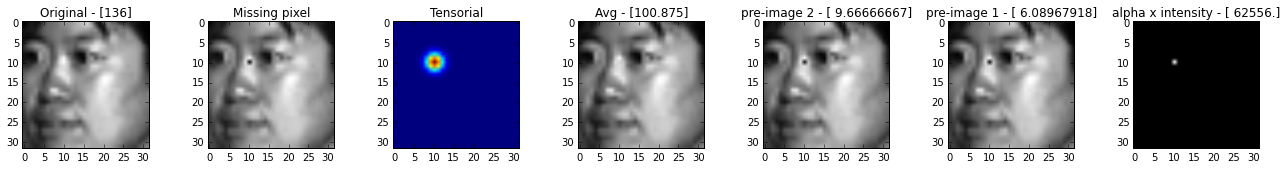

In [19]:
avgm = np.copy(fr.Pixel) 
avgm[fr.pixel_incompletes] = x
print 'Pixel:', fr.X[fr.pixel_incompletes], fr.Y[fr.pixel_incompletes]
print x, fr.MF[image][fr.pixel_incompletes]
f, axarr = plt.subplots(1, 7)
axarr[0].imshow( np.reshape(fr.MF[image],(32,32)).T, cmap='Greys_r' )
axarr[0].set_title('Original - '+str(fr.MF[image][fr.pixel_incompletes]))
axarr[1].imshow( np.reshape(fr.Pixel,(32,32)).T, cmap='Greys_r' )
axarr[1].set_title('Missing pixel')
axarr[2].imshow(np.reshape( kt_ ,(32,32)).T)
axarr[2].set_title('Tensorial')
axarr[3].imshow(np.reshape( avgm ,(32,32)).T, cmap='Greys_r')
axarr[3].set_title('Avg - '+str(x))
axarr[4].imshow(np.reshape( pi2 ,(32,32)).T, cmap='Greys_r')
axarr[4].set_title('pre-image 2 - '+str(pi2[fr.pixel_incompletes]))
axarr[5].imshow(np.reshape( pi1 ,(32,32)).T, cmap='Greys_r')
axarr[5].set_title('pre-image 1 - '+str(pi1[fr.pixel_incompletes]))
axarr[6].imshow(np.reshape( pi3 ,(32,32)).T, cmap='Greys_r')
axarr[6].set_title('alpha x intensity - '+str(pi3[fr.pixel_incompletes]))
f.set_size_inches(18,8)
f.tight_layout()